In [177]:
from coiled import Cluster

cluster = Cluster(n_workers=[4,20])
client = cluster.get_client()

Output()

╭──────────────────────────────── Package Info ────────────────────────────────╮
│                          ╷                                                   │
│   Package                │ Note                                              │
│ ╶────────────────────────┼─────────────────────────────────────────────────╴ │
│   coiled_local_spimquant │ Source wheel built from                           │
│                          │ /local/scratch/SPIMquant/spimquant                │
│   pybids                 │ Wheel built from                                  │
│                          │ git+https://github.com/akhanf/pybids@a9b32a1f61   │
│                          │ 819ee9927d0640b0a97a75005a94cf                    │
│   snakebids              │ Wheel built from                                  │
│                          │ git+https://github.com/akhanf/snakebids@7bfe3d8   │
│                          │ 8ef28802e02a5119d4e9ff6769532cb6f                 │
│   spimquant              │ Wheel built from /local/scratch/SPIMquant         │
│   zarrnii                │ Wheel built from                                  │
│                          │ git+https://github.com/khanlab/zarrnii@fafae58b   │
│                          │ 12181bfc814060eb7832e7d321735541                  │
│                          ╵                                                   │
╰──────────────────────────────────────────────────────────────────────────────╯

Output()

2024-10-29 01:15:45,099 - distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=4 maximum=20


In [3]:
import zarr
import dask.array as da
import dask
from dask.array.overlap import overlap, trim_overlap
import numpy as np
from math import sqrt
from skimage.feature import blob_dog
import sparse
import coiled

In [4]:
in_zarr = 'gcs://khanlab-lightsheet/data/mouse_appmaptapoe/bids/sub-F1A1Te4/micr/sub-F1A1Te4_sample-brain_acq-blaze_SPIM.ome.zarr'

zi = zarr.open(in_zarr)
attrs=zi['/'].attrs.asdict()

#get channel index from omero metadata
channel_labels = [channel_dict['label'] for channel_dict in attrs['omero']['channels']]
channel_index = channel_labels.index('PI')


level=0

#read coordinate transform from ome-zarr
transforms = attrs['multiscales'][0]['datasets'][level]['coordinateTransformations']


In [17]:

0.004 / 0.001625

2.4615384615384617

In [5]:
channel_labels

['Abeta', 'PI', 'Lectin']

# simple thresholding

In [225]:
# use downsampled level to get globally optimum threshold
from skimage.filters import threshold_otsu
from zarrnii import ZarrNii

ds_level=5
hires_level=3

znimg_ds = ZarrNii.from_path(in_zarr,level=ds_level).downsample(along_z=16)
znimg_hires = ZarrNii.from_path(in_zarr,level=hires_level)

znimg_hires_iso = ZarrNii.from_path(in_zarr,level=hires_level).downsample(along_z=4)

znimg_ds.darr





/localscratch/pypoetry_venv/spimquant-FX4pj9UN-py3.11/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


dask.array<coarsen, shape=(1, 95, 373, 287), dtype=float64, chunksize=(1, 1, 373, 287), chunktype=numpy.ndarray>

In [140]:
znimg_hires_iso.darr

dask.array<coarsen, shape=(1, 380, 1494, 1150), dtype=float64, chunksize=(1, 1, 1494, 1150), chunktype=numpy.ndarray>

In [83]:
optimal_threshold = threshold_otsu(znimg_ds.darr.compute())

In [66]:
optimal_threshold

964.6417236328125

In [84]:
def threshold_block(x):
    """ our thresholding function, returns 100 if above, 0 if not"""
    return np.where(x > optimal_threshold, 100, 0)
    #return x>optimal_threshold

In [85]:
#now, we perform thresholding on hires, and save the result in a new ome-zarr 
znimg_hires.darr = znimg_hires.darr.map_blocks(threshold_block,dtype=np.uint8,meta=np.array((), dtype=np.uint8))
znimg_hires.darr

dask.array<threshold_block, shape=(1, 1520, 1494, 1150), dtype=uint8, chunksize=(1, 1, 1494, 1150), chunktype=numpy.ndarray>

In [86]:
out_uri=f'gcs://khanlab-lightsheet/data/temp/sub-F1A1Te4_sample-brain_acq-blaze_desc-otsu_level-{hires_level}_maskfix.ome.zarr'

znimg_hires.to_ome_zarr(out_uri,max_layer=3)

In [87]:
#we already computed the graph, written out to zarr, 
#so now if we want to make use of the data, we use from_path again
ZarrNii.from_path(out_uri,level=3).to_nifti('test_threshold_downsampled-3_fix.nii')



/localscratch/pypoetry_venv/spimquant-FX4pj9UN-py3.11/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [88]:
#so we can overlay:
ZarrNii.from_path(in_zarr,level=3,channels=[0]).to_nifti('test_downsampled-3.nii')


/localscratch/pypoetry_venv/spimquant-FX4pj9UN-py3.11/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [93]:
ZarrNii.from_path(in_zarr,level=4,channels=[0]).downsample(along_z=8).to_nifti('test_downsampled-4_iso.nii')


/localscratch/pypoetry_venv/spimquant-FX4pj9UN-py3.11/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [156]:
ZarrNii.from_path(in_zarr,level=4,channels=[0]).downsample(along_z=8).darr

/localscratch/pypoetry_venv/spimquant-FX4pj9UN-py3.11/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


dask.array<coarsen, shape=(1, 190, 747, 575), dtype=float64, chunksize=(1, 1, 747, 575), chunktype=numpy.ndarray>

# N4 with antspyx

In [94]:
import ants
import matplotlib.pyplot as plt

In [96]:
antsimg = ants.image_read('test_downsampled-4_iso.nii')

In [117]:
antsimg_n4 = ants.n4_bias_field_correction(antsimg,spline_param=(16,16,16),shrink_factor=8,return_bias_field=False)
antsimg_bias = ants.n4_bias_field_correction(antsimg,spline_param=(16,16,16),shrink_factor=8,return_bias_field=True)

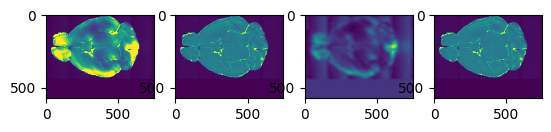

In [127]:
#plot before/after n4, and biasfield
plt.subplot(1,4,1)
plt.imshow(antsimg.numpy()[:,:,90],vmax=2000)
plt.subplot(1,4,2)
plt.imshow(antsimg_n4.numpy()[:,:,90],vmax=2000)
plt.subplot(1,4,3)
plt.imshow(antsimg_bias.numpy()[:,:,90],vmax=5)
plt.subplot(1,4,4)
plt.imshow((antsimg.numpy()/antsimg_bias.numpy())[:,:,90],vmax=2000)

In [154]:
antsimg.shape

(575, 747, 190)

In [146]:
ants.image_write(antsimg_bias,'test_biasfield.nii')

In [179]:
#ok, now we have the bias field.. let's resample it to the level 
# where we perform thresholding
#znimg_ds4 = ZarrNii.from_path(in_zarr,level=4,channels=[0]).downsample(along_z=8)

#znimg_ds4.darr = da.array(antsimg_bias.numpy())
zarr_bf = f'gcs://khanlab-lightsheet/data/temp/sub-F1A1Te4_sample-brain_acq-blaze_level-4iso_N4biasfield.ome.zarr'
#zarr_bf = f'sub-F1A1Te4_sample-brain_acq-blaze_level-4iso_N4biasfield.ome.zarr'

znimg_biasfield = ZarrNii.from_path('test_biasfield.nii')
znimg_biasfield.to_ome_zarr(zarr_bf)



/localscratch/pypoetry_venv/spimquant-FX4pj9UN-py3.11/lib/python3.11/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 622.65 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [226]:
znimg_biasfield_gcs = ZarrNii.from_path(zarr_bf)

In [213]:
#try resizing using map_blocks
from scipy.ndimage import zoom

upsampled_processed = da.empty(znimg_hires_iso.darr.shape, chunks=znimg_hires_iso.darr.chunks, dtype=znimg_hires_iso.darr.dtype)
upsampled_processed

#darr_bf_zoomed = da.map_blocks(lambda x: zoom(x,(1,2,2,2)),znimg_biasfield_gcs.darr,dtype=znimg_biasfield.darr.dtype)

dask.array<empty_like, shape=(1, 380, 1494, 1150), dtype=float32, chunksize=(1, 1, 1494, 1150), chunktype=numpy.ndarray>

In [227]:
def upsample_block(refblock,block, scale_factors):
    from scipy.ndimage import zoom
    return zoom(block, scale_factors)

znimg_hires_iso.darr = znimg_hires_iso.darr.rechunk((1,2,-1,-1))

scale_factors=(1,2,2,2)
# Apply map_blocks, specifying the block size change
upsampled_processed = da.map_blocks(
    upsample_block,
    znimg_hires_iso.darr,
    znimg_biasfield_gcs.darr,
    scale_factors=scale_factors,
)

In [228]:
upsampled_processed

dask.array<upsample_block, shape=(1, 380, 747, 575), dtype=float64, chunksize=(1, 2, 297, 296), chunktype=numpy.ndarray>

In [229]:
upsampled_processed.to_zarr(f'gcs://khanlab-lightsheet/data/temp/sub-F1A1Te4_sample-brain_acq-blaze_level-3upsampled_N4biasfield_test.zarr',overwrite=True)


KeyboardInterrupt: 

In [220]:
znimg_biasfield_gcs.darr

dask.array<rechunk-p2p, shape=(1, 190, 747, 575), dtype=float64, chunksize=(1, 1, 747, 575), chunktype=numpy.ndarray>

dask.array<truediv, shape=(1, 380, 1494, 1150), dtype=float32, chunksize=(1, 1, 1494, 1150), chunktype=numpy.ndarray>

In [208]:
znimg_biasfield_gcs = ZarrNii.from_path(zarr_bf,chunks=(1,1,-1,-1),rechunk=True)
znimg_biasfield_gcs.darr

/localscratch/pypoetry_venv/spimquant-FX4pj9UN-py3.11/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


dask.array<rechunk-p2p, shape=(1, 190, 747, 575), dtype=float64, chunksize=(1, 1, 747, 575), chunktype=numpy.ndarray>

In [184]:

from zarrnii import Transform

znimg_upsampled = znimg_biasfield_gcs.apply_transform(Transform.affine_ras_from_array(np.eye(4)),ref_znimg=znimg_hires_iso)
znimg_upsampled.darr

dask.array<interp_by_block, shape=(1, 380, 1494, 1150), dtype=float32, chunksize=(1, 1, 1494, 1150), chunktype=numpy.ndarray>

In [185]:
zarr_bf_upsampled = f'gcs://khanlab-lightsheet/data/temp/sub-F1A1Te4_sample-brain_acq-blaze_level-3upsampled_N4biasfield.ome.zarr'

znimg_upsampled.to_ome_zarr(zarr_bf_upsampled,max_layer=3)

In [187]:
#now we have bias field upsampled, so lets apply it
znimg_bf_upsampled = ZarrNii.from_path(zarr_bf_upsampled)
znimg_bf_upsampled.darr

dask.array<getitem, shape=(1, 380, 1494, 1150), dtype=float32, chunksize=(1, 19, 1494, 1150), chunktype=numpy.ndarray>

In [188]:
znimg_hires_iso.darr

dask.array<interp_by_block, shape=(1, 380, 1494, 1150), dtype=float32, chunksize=(1, 1, 1494, 1150), chunktype=numpy.ndarray>

In [190]:
znimg_hires_iso.darr  = znimg_hires_iso.darr / znimg_bf_upsampled.darr
znimg_hires_iso.to_ome_zarr(f'gcs://khanlab-lightsheet/data/temp/sub-F1A1Te4_sample-brain_acq-blaze_level-3dsZ_desc-applyN4_SPIM.ome.zarr',max_layer=3)


In [191]:
#now let's read in our corrected image, downsampled:
znimg_n4 = ZarrNii.from_path(f'gcs://khanlab-lightsheet/data/temp/sub-F1A1Te4_sample-brain_acq-blaze_level-3dsZ_desc-applyN4_SPIM.ome.zarr',level=3)
znimg_n4.darr

/localscratch/pypoetry_venv/spimquant-FX4pj9UN-py3.11/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


dask.array<getitem, shape=(1, 380, 186, 143), dtype=float32, chunksize=(1, 19, 186, 143), chunktype=numpy.ndarray>

In [192]:
znimg_n4.to_nifti('test_corrected.nii')

# blob detection

In [5]:
#setup parameters
min_sigma_um=1
max_sigma_um=100  # also serves as size of chunk borders
threshold=0.06
chunks=(1, 127, 122, 116)
chunks=(1, 200, 200, 200)

darr_chan = da.from_zarr(in_zarr,component=f'{level}',chunks=chunks)[channel_index,:,:,:]

print(f'before adding overlap:')
print(f'shape: {darr_chan.shape}')
print(f'chunks: {darr_chan.chunks}')

#adjust sigma based on physical size of voxels --- TODO check this! 
# get um per pixel from the scaling transforms
# then convert from um to pixel by dividing by it
scaling_zyx=np.array(transforms[0]['scale'][1:])
print(f'scaling_zyx: {scaling_zyx}') 
#mm per pixel

min_sigma_px = min_sigma_um *1e-3 / scaling_zyx 
max_sigma_px = max_sigma_um *1e-3 / scaling_zyx
boundary_px = tuple(max_sigma_px.astype('int').tolist())

print(f'min_sigma_px: {min_sigma_px}')
print(f'max_sigma_px: {max_sigma_px}')
print(f'boundary_px: {boundary_px}')

/localscratch/pypoetry_venv/spimquant-FX4pj9UN-py3.11/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


before adding overlap:
shape: (1520, 11957, 9206)
chunks: ((200, 200, 200, 200, 200, 200, 200, 120), (200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 157), (200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 6))
scaling_zyx: [0.004    0.001625 0.001625]
min_sigma_px: [0.25       0.61538462 0.61538462]
max_sigma_px: [25.         61.53846154 61.53846154]
boundary_px: (25, 61, 61)


In [64]:
darr_chan

dask.array<getitem, shape=(1520, 747, 575), dtype=uint16, chunksize=(200, 200, 200), chunktype=numpy.ndarray>

In [6]:

def detect_blobs(x,block_info=None):

    #we need local chunk location in order to translate the local blob
    #coords into global blob coords
    arr_location = block_info[0]['array-location']

    blobs_dog = blob_dog(x, min_sigma=min_sigma_px, max_sigma=max_sigma_px, 
            threshold=threshold, exclude_border=boundary_px)

    #we have coordinates, now convert to a volumetric representation
    #-- (index,sigma_0,sigma_1,sigma_2) -- this requires 

    blobs_dog[:, 3:] = blobs_dog[:, 3:] * sqrt(3) #adjust each sigma to get radius (this is still in pixels)

    blobs_img = np.zeros((x.shape[0],x.shape[1],x.shape[2],4),dtype=np.float32)
    for i in range(blobs_dog.shape[0]):
        blobs_img[int(blobs_dog[i,0]),int(blobs_dog[i,1]),int(blobs_dog[i,2]),0] = i+1 #set to index for now (1-indexed)
        for sigma_i in range(3):
            blobs_img[int(blobs_dog[i,0]),int(blobs_dog[i,1]),int(blobs_dog[i,2]),1+sigma_i] = blobs_dog[i,sigma_i] 

    return blobs_img


In [17]:

expanded = overlap(darr_chan, depth=boundary_px, boundary=0)
expanded

dask.array<getitem, shape=(2120, 381, 293), dtype=uint16, chunksize=(177, 124, 118), chunktype=numpy.ndarray>

In [18]:


darr_blobs = expanded.map_blocks(detect_blobs,dtype=np.float32,meta=np.array((), dtype=np.float32))
darr_blobs

dask.array<detect_blobs, shape=(2120, 381, 293), dtype=float32, chunksize=(177, 124, 118), chunktype=numpy.ndarray>

In [19]:

darr_blobs_trim = trim_overlap(darr_blobs,depth=boundary_px,boundary=0)
darr_blobs_trim

dask.array<_trim, shape=(1520, 373, 287), dtype=float32, chunksize=(127, 122, 116), chunktype=numpy.ndarray>

In [20]:
sparse_array = darr_blobs_trim.map_blocks(sparse.COO)
sparse_array

dask.array<COO, shape=(1520, 373, 287), dtype=float32, chunksize=(127, 122, 116), chunktype=sparse.COO>

In [21]:
sparse_array_npy = sparse_array.compute()

In [22]:
sparse_array_npy

Format,coo
Data Type,float32
Shape,"(1520, 373, 287, 4)"
nnz,13588
Density,2.0876670195071804e-05
Read-only,True
Size,477.7K
Storage ratio,0.00


In [24]:
scaled_coords = sparse_array_npy[:,:,:,0].coords.T * scaling_zyx.reshape(1,3)
scaled_coords

array([[ 0.056,  9.724,  6.864],
       [ 0.064,  8.632,  4.68 ],
       [ 0.096, 10.452,  7.488],
       ...,
       [ 6.028, 16.952,  6.188],
       [ 6.028, 17.056,  6.084],
       [ 6.04 , 15.652,  7.488]])

In [25]:
scaled_coords.shape

(3397, 3)

In [26]:
import matplotlib.pyplot as plt

(-0.9672, 20.311199999999996, -0.28600000000000003, 11.725999999999999)

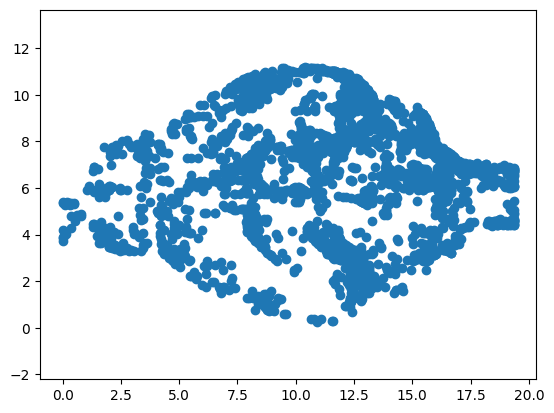

In [31]:
plt.scatter(scaled_coords[:,1],scaled_coords[:,2])
plt.axis('equal')

# MIP on level4

In [26]:
darr_3chan = da.from_zarr(in_zarr,component='1')#,chunks=(1,200,200,200))
darr_3chan

/localscratch/pypoetry_venv/spimquant-FX4pj9UN-py3.11/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


dask.array<from-zarr, shape=(3, 1520, 5978, 4603), dtype=uint16, chunksize=(1, 1, 4096, 4096), chunktype=numpy.ndarray>

In [27]:
#get MIP of each chan
darr_mip=[]
for i in range(3):
    darr_mip.append(da.max(darr_3chan[i],axis=0))

darr_mip_npy = np.zeros(darr_mip[0].shape + (3,))
darr_mip[0]

dask.array<max-aggregate, shape=(5978, 4603), dtype=uint16, chunksize=(4096, 4096), chunktype=numpy.ndarray>

In [28]:
for i in range(1): # no rechunking level=1
    darr_mip_npy[:,:,i] = darr_mip[i].compute() 

In [29]:
import matplotlib.pyplot as plt

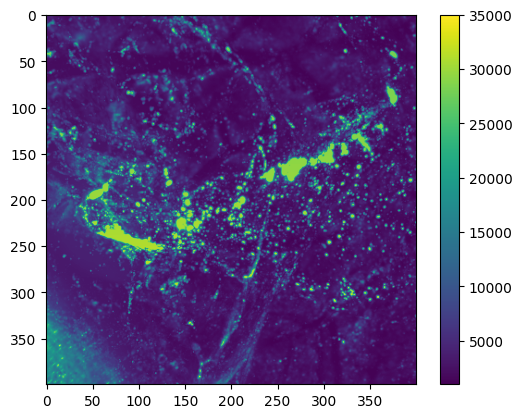

In [41]:
plt.imshow(darr_mip_npy[3000:3400,2400:2800,0],vmax=35000) #Abeta
plt.colorbar()

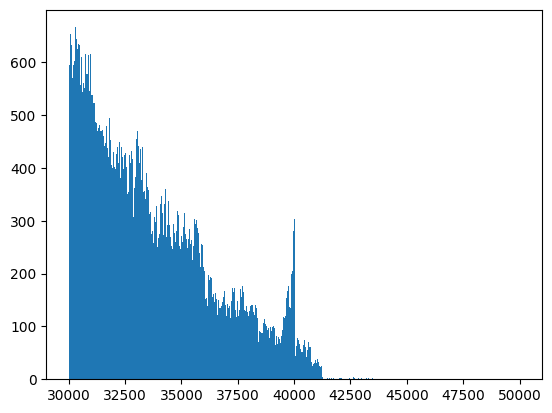

In [62]:
plt.hist(darr_mip_npy[:,:,0].flatten(),bins=1000,range=(30000,50000));

In [51]:
darr_mip_npy.shape

(5978, 4603, 3)

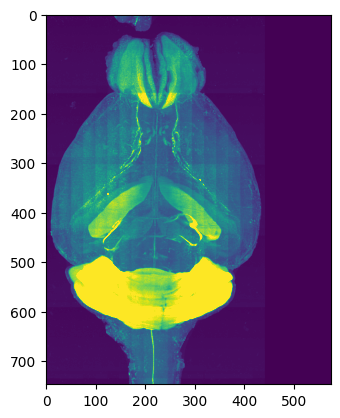

In [101]:
plt.imshow(darr_mip_npy[:,:,1],vmin=0,vmax=3000) #PI

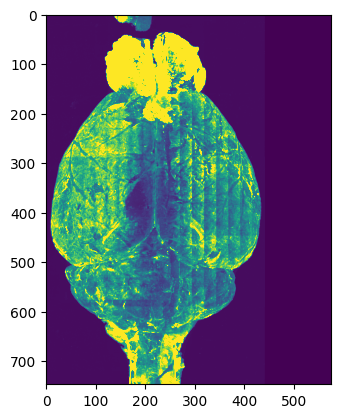

In [99]:
plt.imshow(darr_mip_npy[:,:,2],vmax=8000) #Lectin

# MIP on level0 cropped

In [151]:
darr_3chan = da.from_zarr(in_zarr,component='0',chunks=(1,1,200,200)).blocks[:,:,28:32,23:27]

darr_3chan


/localscratch/pypoetry_venv/spimquant-FX4pj9UN-py3.11/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


dask.array<blocks, shape=(3, 1520, 800, 800), dtype=uint16, chunksize=(1, 1, 200, 200), chunktype=numpy.ndarray>

In [141]:
#crop
#darr_3chan = darr_3chan[:,:,5000:6000,4000:5000]
darr_3chan

dask.array<blocks, shape=(3, 1520, 200, 200), dtype=uint16, chunksize=(1, 1, 200, 200), chunktype=numpy.ndarray>

In [152]:
#get MIP of each chan
darr_mip=[]
for i in range(3):
    darr_mip.append(da.max(darr_3chan[i],axis=0))

darr_mip_npy = np.zeros(darr_mip[0].shape + (3,))
darr_mip[0]

dask.array<max-aggregate, shape=(800, 800), dtype=uint16, chunksize=(200, 200), chunktype=numpy.ndarray>

In [153]:
for i in range(3):
    darr_mip_npy[:,:,i] = darr_mip[i].compute()

KeyboardInterrupt: 

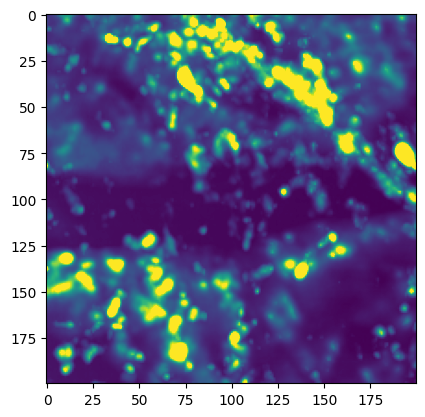

In [146]:
plt.imshow(darr_mip_npy[:,:,0],vmax=12000) #Abeta

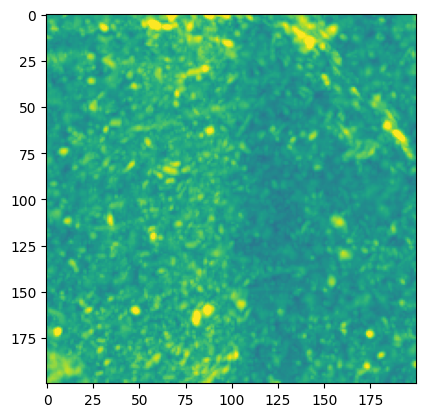

In [147]:
plt.imshow(darr_mip_npy[:,:,1],vmin=0,vmax=3000) #PI

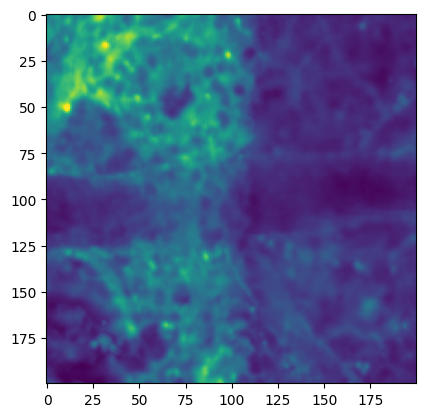

In [150]:
plt.imshow(darr_mip_npy[:,:,2],vmax=12000) #Lectin